# Emotion Detectio with EEG Signals

## Table of content

<ul>
    <li><a href="#i">Import Packages</a></li>
    <li><a href="#dw">Data Wrangling</a></li>
        <ul>
            <li><a href="#r">Reading EEG Data</a></li>
            <li><a href="#v">Viewing a Sample</a></li>
        </ul>
    <li><a href="#dp">Data Pre-processing</a></li>
    <li><a href="#dl">Deep Learning
        <ul>
            <li><a href="#ma">Model Architecture</a></li>
            <li><a href="#mt">Model Training</a></li>
            <li><a href="#mh">Plotting the model history curves</a></li>
            <li><a href="#me">Model Evaluation</a></li>
            <li><a href="#hm">Plotting the heatmap and Classification Report</a></li>
        </ul>
        </a></li>
</ul>

<a id="i"></a>
## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from tensorflow import keras
import tensorflow.compat.v1 as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

<a id="dw"></a>
## Data Wrangling

<a id="r"></a>
### Reading EEG data

In [2]:
df = pd.read_csv(r"emotions.csv")

In [3]:
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


<a id="v"></a>
### Viewing a sample

In [4]:
fft_data = df.loc[:,'fft_0_b':'fft_749_b']
fft_data

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,105.0,3.37,29.20,29.20,3.37,151.0,-19.40,8.89,8.89,-19.40,...,155.0,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90
2128,-23.0,202.00,-81.60,-81.60,202.00,-345.0,404.00,-205.00,-205.00,404.00,...,-661.0,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00
2129,-288.0,312.00,-259.00,-259.00,312.00,-186.0,276.00,-199.00,-199.00,276.00,...,-232.0,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00
2130,109.0,2.48,49.00,49.00,2.48,-230.0,216.00,-92.40,-92.40,216.00,...,-99.7,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00


<AxesSubplot:>

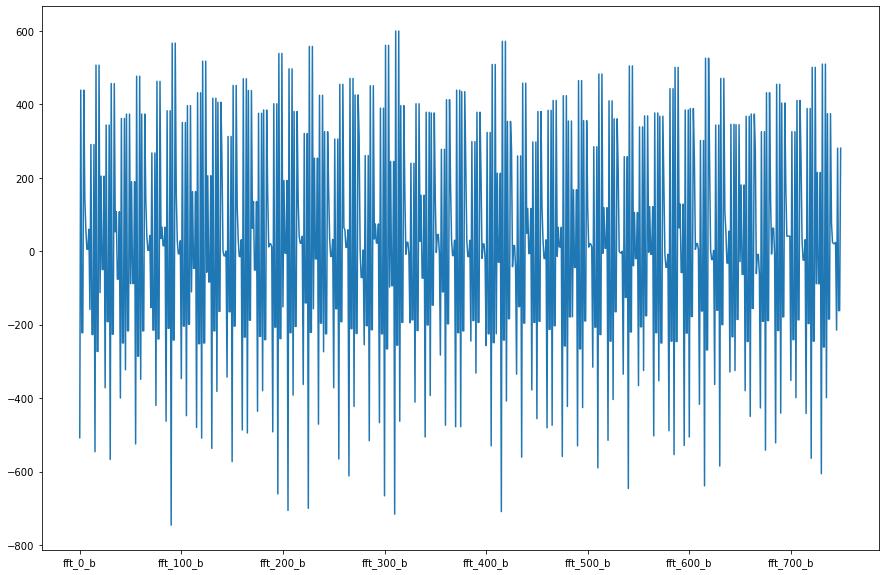

In [5]:
fft_data.iloc[0,:].plot(figsize=(15,10))

<a id="dp"></a>
## Data Pre-processing

In [6]:
le = LabelEncoder()
df['label']=le.fit_transform(df['label'])

In [7]:
y = df.pop('label')
X = df

In [8]:
y

0       0
1       1
2       2
3       2
4       1
       ..
2127    1
2128    2
2129    0
2130    0
2131    1
Name: label, Length: 2132, dtype: int32

<a id="ds"></a>

### Splitting the data into train, test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=48)

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

In [10]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

<a id="dl"></a>
## Deep Learning Model

<a id="ma"></a>
### Model Architecture 

In [11]:
model = Sequential()
model.add(Input((X_train.shape[1], 1)))
model.add(LSTM(256, return_sequences=True))
model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Dense(3, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2548, 256)         264192    
                                                                 
 flatten (Flatten)           (None, 652288)            0         
                                                                 
 dense (Dense)               (None, 64)                41746496  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 42,012,867
Trainable params: 42,012,867
No

<a id="mt"></a>
### Training the model. 

In [13]:
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [16]:
model_history = model.fit(X_train, y_train,
         validation_data=(X_test, y_test),
          batch_size = 32,
         epochs = 15,
         callbacks=[es])

Epoch 1/15
20/20 [==============================] - 12s 423ms/step - loss: 113.0865 - accuracy: 0.7152 - val_loss: 24.1952 - val_accuracy: 0.9109
Epoch 2/15
20/20 [==============================] - 8s 418ms/step - loss: 40.4311 - accuracy: 0.8717 - val_loss: 34.0735 - val_accuracy: 0.8868
Epoch 3/15
20/20 [==============================] - 8s 412ms/step - loss: 11.8774 - accuracy: 0.9014 - val_loss: 3.4894 - val_accuracy: 0.9337
Epoch 4/15
20/20 [==============================] - 8s 417ms/step - loss: 2.6855 - accuracy: 0.9452 - val_loss: 4.3921 - val_accuracy: 0.9290
Epoch 5/15
20/20 [==============================] - 8s 417ms/step - loss: 2.3295 - accuracy: 0.9515 - val_loss: 3.1257 - val_accuracy: 0.9397
Epoch 6/15
20/20 [==============================] - 8s 400ms/step - loss: 1.2352 - accuracy: 0.9609 - val_loss: 3.0705 - val_accuracy: 0.9444
Epoch 7/15
20/20 [==============================] - 8s 405ms/step - loss: 1.0869 - accuracy: 0.9734 - val_loss: 2.8518 - val_accuracy: 0.9498

<a id="s"></a>
### Model Saving

In [17]:
model.save("D://Emotion_classification")

INFO:tensorflow:Assets written to: D://Emotion_classification/assets


INFO:tensorflow:Assets written to: D://Emotion_classification/assets


<a id="mh"></a>
### Plotting the model history curves 

In [18]:
Model_history_df = pd.DataFrame(model_history.history)

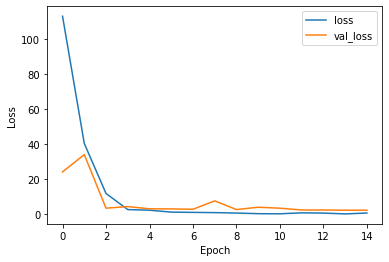

In [19]:
Model_history_df.loc[:, ['loss', 'val_loss']].plot()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

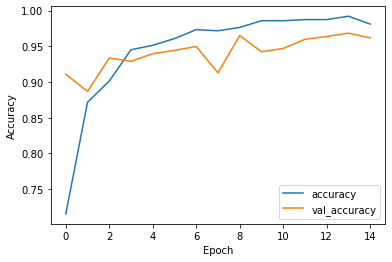

In [21]:
Model_history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

<a id="me"></a>
### Evaluating the model 

In [22]:
train_acc = model.evaluate(X_train, y_train, verbose=1)
train_acc

20/20 [==============================] - 2s 78ms/step - loss: 0.0599 - accuracy: 0.9953


[0.05994049459695816, 0.9953051805496216]

In [23]:
test_acc = model.evaluate(X_test, y_test, verbose=1)
test_acc

47/47 [==============================] - 4s 78ms/step - loss: 2.3191 - accuracy: 0.9618


[2.3191332817077637, 0.9618218541145325]

<a id="hm"></a>
### Plotting Heatmap and Classification Report

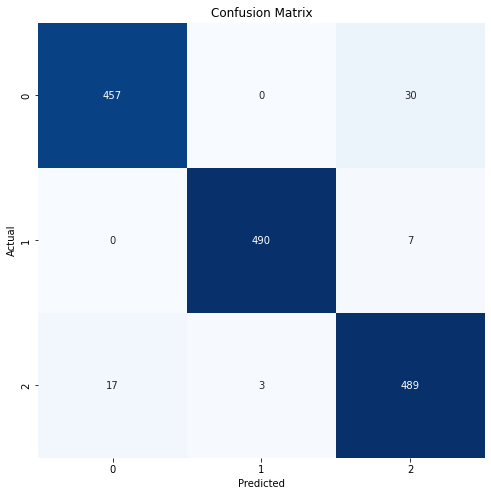

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       487
           1       0.99      0.99      0.99       497
           2       0.93      0.96      0.94       509

    accuracy                           0.96      1493
   macro avg       0.96      0.96      0.96      1493
weighted avg       0.96      0.96      0.96      1493



In [26]:
y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
y_test = y_test.idxmax(axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)